# Assignment 3
**Due date/time:** Mar 6th Wed 23:59pm

**Instruction**: Make a copy of this notebook and read through the questions and instructions. Write down code/text to perform the analysis.

**Submission**: After you finish working on this notebook, click File->Download->Download .ipynb

Please submit a notebook named A3_your_name.ipynb on Canvas.

## Detailed instructions:

In this assignment, we will practie on model selection and spatial autocorrelation.

**Note**: From this assignment and onward, if you are interested in performing your analysis using your own data (e.g., you may have a dataset from a research project), you are very encouraged to do so.

We will be re-using our county-level health data `health` obtained from [CDC](https://www.cdc.gov/places/index.html) to investigate [Social Determinants of Health](https://www.cdc.gov/about/sdoh/index.html). You can find the explanations to the columns in the data [here](https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/cdc_county_health.txt).

You are also given a county-level socio-demographic dataset `socio_demo` obtaiend from the American Community Survey (2015-2019) dataset. Variable name explanations can be seen [here](https://github.com/Ziqi-Li/GIS5122/blob/main/data/acs_2019_variables.txt).

The objective is to identify socio-demographic factors that will explain health outcome inequality in the US, by estimating a regression model.

You are also given a county-level boundary file `counties` for making necessary maps.

Below are specific tasks you need to perform and their credits (total 100%):
1. Create a `GeoDataFrame` by merging the `health`, the `socio_demo` and the `counties` boundary together. Code is given.
2. Choose **ONE** health outcome of your interest. Make a map of the health outcome to show its spatial distribution. (**5%**)
3. Build a linear regression model (OLS) with the health outcome as the dependent variable, and socio-demographic variables as the independent variables. You are supposed to tweak the model specification based on your own understanding of the potential relationships. Optionally but not required, you can use the forward/backward/stepwise selection code (autoselect.py) to help you decide which predictors you want to include in your model. Report and interpret your linear regression results regarding your model R2, regression coefficients, and statistical significance of the coefficients. (**30%**)
5. Create a residual vs fit plot and a Q-Q plot to check the model residual assumptions. Describe whether the patterns in these plots noticeably violate any of the LINE regression assumptions. In this speficic assignment, you are only expected to diagnose issues but you don't need to fix the issues. (**10%**)
6. Make a map of the residuals to examine spatial autocorrelation. Then compute Moran's I value of the residuals based on Queen-contiguity spatial weights matrix. Interpret the Moran's I value and its statistical significance. (**15%**)
7. Fit both a spatial lag model and a spatial error model and cross compare all three methods (slm, sem, ols) and indicate which model we should use based on the evidence from 1) AIC; 2) L-M test and 3) residual spatial autocorrelation. (**40%**)



You may need to install these two packages:

In [1]:
pip install -q libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.2 MB/s eta 0:00:00


In [2]:
pip install -q splot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 10.7 MB/s eta 0:00:00


Import all the packages needed to run the analysis

In [3]:
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from libpysal.weights import Queen
from splot.esda import plot_moran
from esda.moran import Moran
import spreg

Code to read in data and merge them into one final `GeoDataFrame`.

In [4]:
health_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/cdc_health_county.csv"
health = pd.read_csv(health_url)

In [5]:
socio_demo_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/acs_2019.csv"
socio_demo = pd.read_csv(socio_demo_url)

In [6]:
counties_url = "https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson"
counties = gpd.read_file(counties_url)

In [7]:
income_health = pd.merge(socio_demo, health, left_on = "county_id", right_on = "LocationID")

In [8]:
gdf_income_health = pd.merge(counties, income_health, on = "county_id")

Your code will start here, and your analysis will be based on this GeoDataFrame `gdf_income_health`.

# **2. Choose ONE health outcome of your interest. Make a map of the health outcome to show its spatial distribution. (5%)**

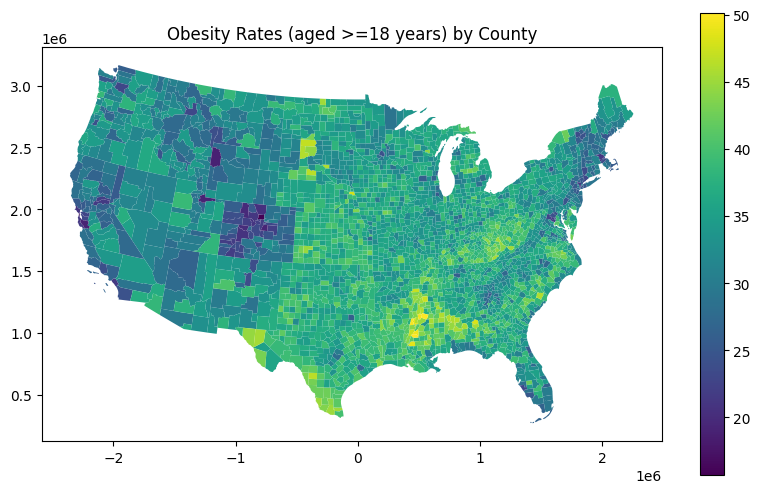

In [9]:
gdf_income_health.plot(column='OBESITY', legend=True, figsize=(10, 6))
plt.title('Obesity Rates (aged >=18 years) by County')
plt.show()

# **3. Build a linear regression model (OLS) with the health outcome as the dependent variable, and socio-demographic variables as the independent variables. You are supposed to tweak the model specification based on your own understanding of the potential relationships.**

In [40]:
variable_names = ['sex_ratio', 'median_income', 'gini',
                  'pct_age_18_29', 'pct_65_over', 'pct_bach']


y = gdf_income_health[['OBESITY']].values

X = gdf_income_health[variable_names].values

In [41]:
ols = spreg.OLS(y, X, name_y='OBESITY', name_x=variable_names)

In [42]:
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           7
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3096
R-squared           :      0.5392
Adjusted R-squared  :      0.5384
Sum squared residual:     28751.3                F-statistic           :    603.9109
Sigma-square        :       9.287                Prob(F-statistic)     :           0
S.E. of regression  :       3.047                Log likelihood        :   -7857.092
Sigma-square ML     :       9.266                Akaike info criterion :   15728.183
S.E of regression ML:      3.0440                Schwarz criterion     :   15770.464

------------------------------------------------------------

In [13]:
ols.u

array([[ 2.29073747],
       [-3.13899696],
       [ 0.53054639],
       ...,
       [ 3.65503049],
       [-3.2120907 ],
       [-0.49921921]])

### **3.1 Optionally but not required, you can use the forward/backward/stepwise selection code (autoselect.py) to help you decide which predictors you want to include in your model. Report and interpret your linear regression results regarding your model R2, regression coefficients, and statistical significance of the coefficients.**

In [14]:
def backward_model_selection(y_name, X_names, df):
    """
    y_name: the column name of the depdent variable in the dataframe df

    X_names: the column names of candidate predictors

    df: the dataframe

    """
    if X_names == []:
        print("\nstop")
        return

    y = df[y_name]
    X = df[X_names]
    X = sm.add_constant(X)
    current_model = sm.OLS(y,X).fit()
    print("\nCurrent model:",y_name,'~',' + '.join(['intercept'] + X_names))
    print('{:>0}  {:>12}  {:>10}'.format(" ", "current", np.around(current_model.aic,2)))

    best_aic = current_model.aic
    to_drop = None

    for x in X_names:
        no_x = [a for a in X_names if a != x]
        X = df[no_x]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        print('{:>0}  {:>12}  {:>10}'.format("-", x, np.around(model.aic,2)))
        if model.aic <= best_aic:
            to_drop = x
            best_aic = model.aic

    if to_drop:
        X_names.remove(to_drop)
        print("dropping ",to_drop)
        backward_model_selection(y_name, X_names, df)

    else:
        print("\nstop")
        print("\nFinal model:",y_name,'~',' + '.join(['intercept'] + X_names))
        return


In [15]:
y_name = 'OBESITY'
X_names = ['total_pop','sex_ratio','pct_black','pct_hisp','pct_bach','median_income',
           'pct_65_over','pct_age_18_29','gini','pct_manuf','ln_pop_den','pct_fb','pct_uninsured']
backward_model_selection(y_name, X_names, gdf_income_health)


Current model: OBESITY ~ intercept + total_pop + sex_ratio + pct_black + pct_hisp + pct_bach + median_income + pct_65_over + pct_age_18_29 + gini + pct_manuf + ln_pop_den + pct_fb + pct_uninsured
        current    15402.55
-     total_pop    15415.58
-     sex_ratio    15429.19
-     pct_black    15662.52
-      pct_hisp    15420.71
-      pct_bach    15838.15
-  median_income    15443.94
-   pct_65_over    15468.32
-  pct_age_18_29    15412.44
-          gini    15402.35
-     pct_manuf    15402.68
-    ln_pop_den    15400.97
-        pct_fb    15442.48
-  pct_uninsured    15400.55
dropping  pct_uninsured

Current model: OBESITY ~ intercept + total_pop + sex_ratio + pct_black + pct_hisp + pct_bach + median_income + pct_65_over + pct_age_18_29 + gini + pct_manuf + ln_pop_den + pct_fb
        current    15400.55
-     total_pop     15413.7
-     sex_ratio    15427.47
-     pct_black    15663.55
-      pct_hisp    15419.32
-      pct_bach    15841.82
-  median_income    15443.17
-   pc

# **4. Create a residual vs fit plot and a Q-Q plot to check the model residual assumptions. Describe whether the patterns in these plots noticeably violate any of the LINE regression assumptions. In this speficic assignment, you are only expected to diagnose issues but you don't need to fix the issues. (10%)**

*   The relationship between predictors and the dependent variable should be linear. As we can see in this plot, non-linear patterns in the Residual vs. Fit plot.
*   There are some deviations in the tails, particularly at the lower left and upper right, suggesting some outliers in the distribution of residuals. This might imply that the residuals have slight deviations from normality, particularly for extreme values.

In [34]:
y = gdf_income_health['OBESITY']

X = gdf_income_health[['sex_ratio','pct_black','pct_hisp','pct_bach','median_income',
                       'pct_65_over','pct_age_18_29','pct_fb']]

X = sm.add_constant(X)

best_model = sm.OLS(y,X).fit()

In [35]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                OBESITY   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     543.6
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:56:37   Log-Likelihood:                -7697.4
No. Observations:                3103   AIC:                         1.541e+04
Df Residuals:                    3094   BIC:                         1.547e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            47.6132      0.810     58.775      0.000      46.025      49.202
sex_ratio        -0.0277      0.005     -5.557      0.000      -0.037      -0.018
pct_black         0.0702      0.004     17.397      0.000       0.062       0.078
pct_hisp          0.0290      0.006      5.100      0.000       0.018       0.040
pct_bach         -0.2436      0.010    -24.655      0.000      -0.263      -0.224
median_income -5.535e-05   6.84e-06     -8.092      0.000   -6.88e-05   -4.19e-05
pct_65_over      -0.1413      0.017     -8.386      0.000      -0.174      -0.108
pct_age_18_29     0.0711      0.019      3.652      0.000       0.033       0.109
pct_fb           -0.1299      0.015     -8.627      0.000      -0.159      -0.100
==============================================================================
Omnibus:                       24.581   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.467
Skew:                          -0.155   Prob(JB):                     6.58e-07
Kurtosis:                       3.352   Cond. No.                     8.59e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Check residuals plot: found strong non-linearity.**

Text(0.5, 1.0, 'residuals vs fitted plot')

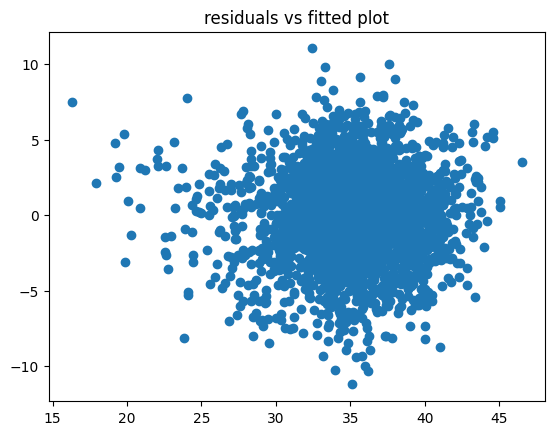

In [21]:
plt.scatter(best_model.predict(),best_model.resid)

plt.title("residuals vs fitted plot")

**Check Q-Q plot**

In [22]:
def q_q_plot(res):
    fig, axes = plt.subplots(1, 2,figsize=(12,4))
    res.hist(ax=axes[0])
    sm.qqplot(res,line='q',ax=axes[1])

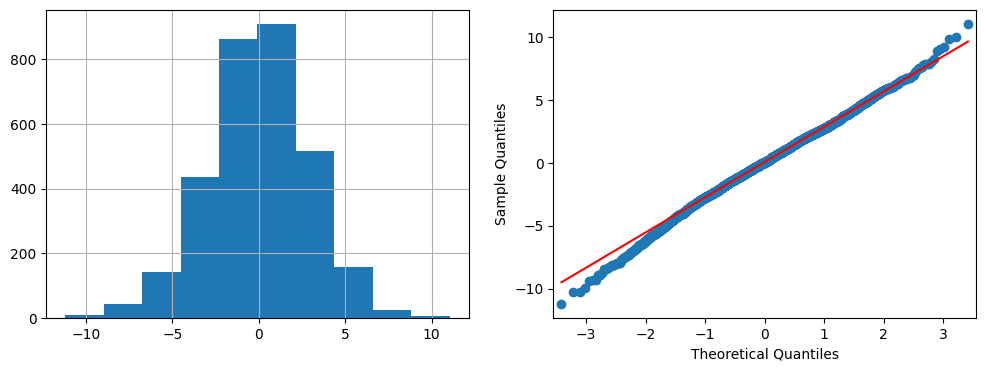

In [23]:
q_q_plot(best_model.resid)

# **5. Make a map of the residuals to examine spatial autocorrelation. Then compute Moran's I value of the residuals based on Queen-contiguity spatial weights matrix. Interpret the Moran's I value and its statistical significance. (15%)**

### **5.1 Make a map of the residuals to examine spatial autocorrelation.**

Text(0.5, 1.0, 'Map of residuals of the OLS model')

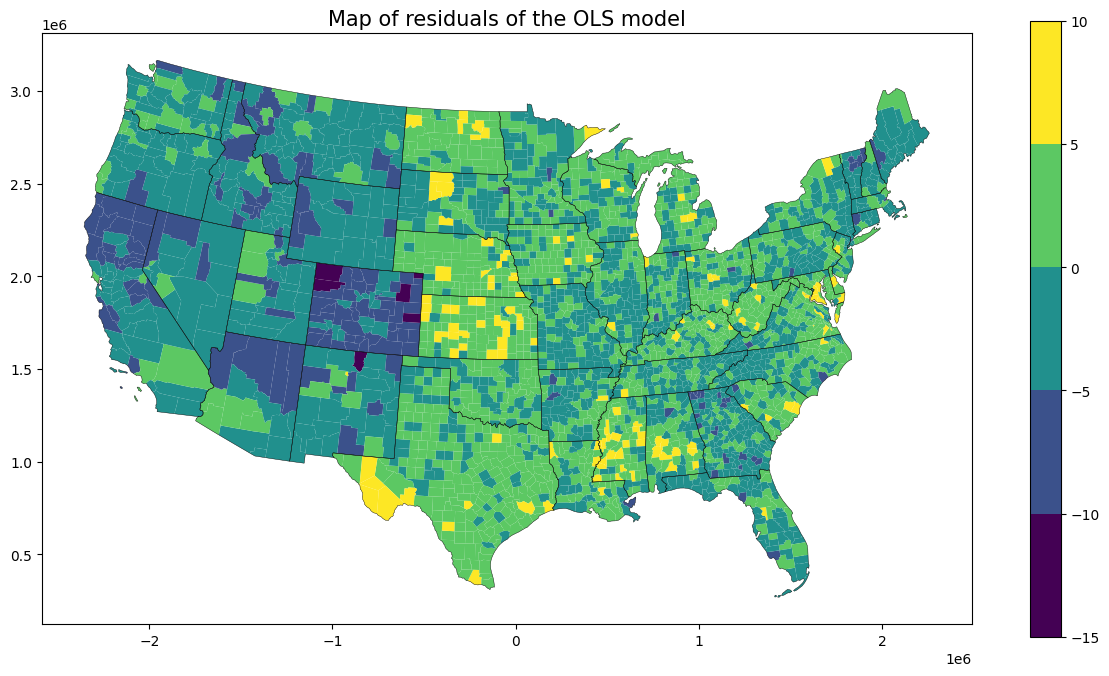

In [26]:
from matplotlib import colors

norm = colors.BoundaryNorm([-15, -10, -5, 0, 5, 10],ncolors=256)

ax = gdf_income_health.plot(column=ols.u.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)

state = gdf_income_health.dissolve(by='state').geometry.boundary
state.plot(ax=ax,linewidth=0.3,edgecolor="black")

plt.title("Map of residuals of the OLS model",fontsize=15)

### **5.2 Compute Moran's I value of the residuals based on Queen-contiguity spatial weights matrix.**

In [27]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(gdf_income_health)

#row standardization
w.transform = 'R'

<ipython-input-27-79034432cd15>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_income_health)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  W.__init__(self, neighbors, ids=ids, **kw)


/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.48', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.48)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

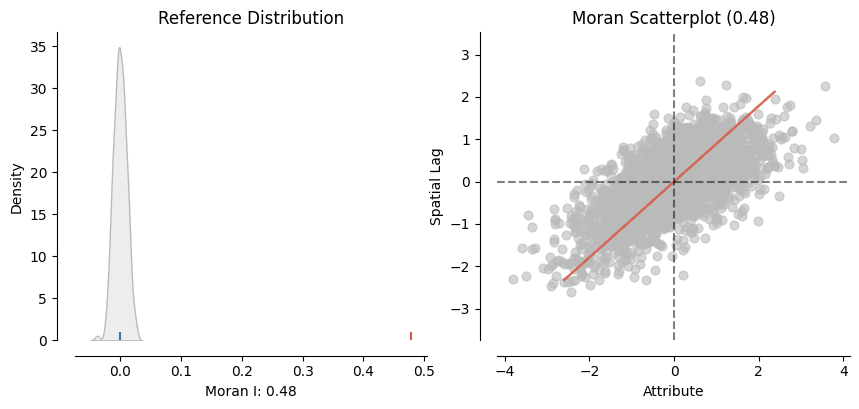

In [28]:
#Here, lets calculate the Moran's I value, and plot it.
#ols.u is the residuals from the OLS model

ols_moran = Moran(ols.u, w, permutations = 199) #199 permutations

plot_moran(ols_moran, figsize=(10,4))

### **5.3 Interpret the Moran's I value and its statistical significance.**

We find that the Moran's I value equals 0.48, which suggests a strong positive spatial autocorrelation. In other words. This reassures us that there is indeed a strong spatial pattern on the OLS's residuals map.


# **6. Fit both a spatial lag model and a spatial error model and cross compare all three methods (slm, sem, ols) and indicate which model we should use based on the evidence from 1) AIC; 2) L-M test and 3) residual spatial autocorrelation. (40%)**

### **Spatial Lag Model**

In [43]:
slm = spreg.ML_Lag(y, X, w=w, name_y='OBESITY', name_x=variable_names)

print(slm.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           8
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3095
Pseudo R-squared    :      0.6866
Spatial Pseudo R-squared:  0.5349
Log likelihood      :  -7341.1293
Sigma-square ML     :      6.3121                Akaike info criterion :   14698.259
S.E of regression   :      2.5124                Schwarz criterion     :   14746.580

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.08', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.08)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

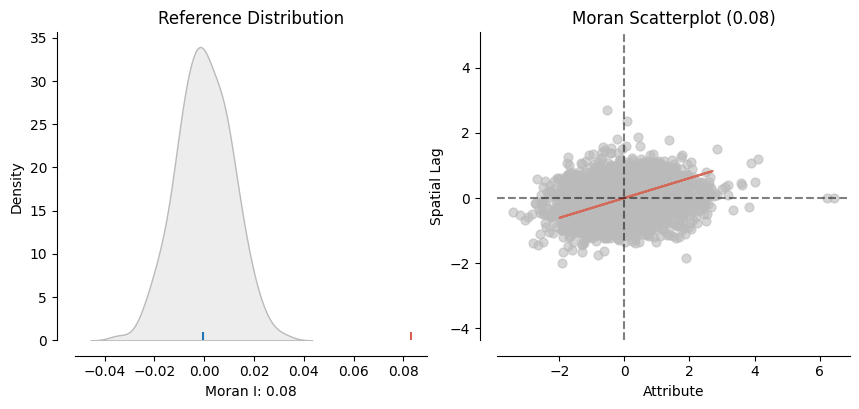

In [44]:
slm_moran = Moran(slm.u, w, permutations = 199) #199 permutations
plot_moran(slm_moran, zstandard=True, figsize=(10,4))

Text(0.5, 1.0, 'Map of residuals of the spatial lag model')

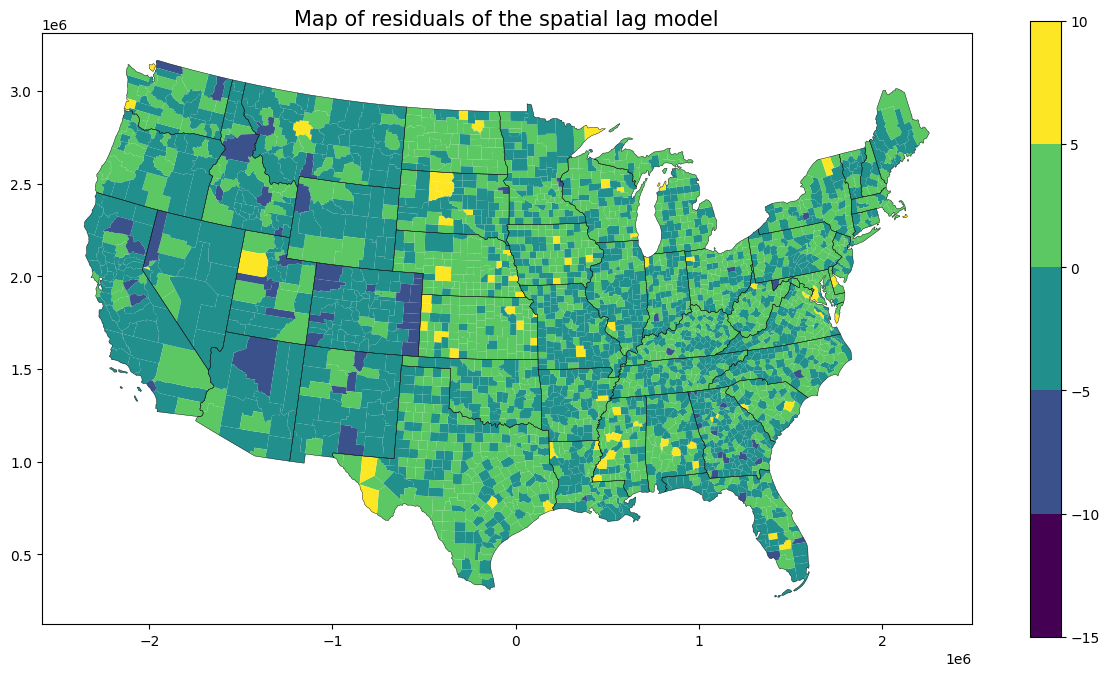

In [45]:
ax = gdf_income_health.plot(column=slm.u.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)

state.plot(ax=ax,linewidth=0.3,edgecolor="black")
plt.title("Map of residuals of the spatial lag model",fontsize=15)

### **Spatial Error Model (SEM)**

In [46]:
sem = spreg.ML_Error(y, X, w=w, name_x=variable_names, name_y='OBESITY')

print(sem.summary)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           7
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3096
Pseudo R-squared    :      0.5324
Log likelihood      :  -7156.7291
Sigma-square ML     :      5.2529                Akaike info criterion :   14327.458
S.E of regression   :      2.2919                Schwarz criterion     :   14369.739

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        46.93953    

The lambda coefficint for the spatially lagged error term is significant, and the magnitude is quite large, this is suggesting that there is a strong spatial autocorrelation in the residuals which is captured in the lagged error term.

The lambda coefficient in the spatial error model highlights a strong spatial autocorrelation in obesity rates, indicating that the obesity rates in neighboring areas tend to be similar.

In [47]:
sem.e_filtered

array([[ 3.91576152],
       [-2.87724708],
       [-0.7400819 ],
       ...,
       [ 1.35951161],
       [-1.2500231 ],
       [ 0.96512756]])

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: -0.06', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (-0.06)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

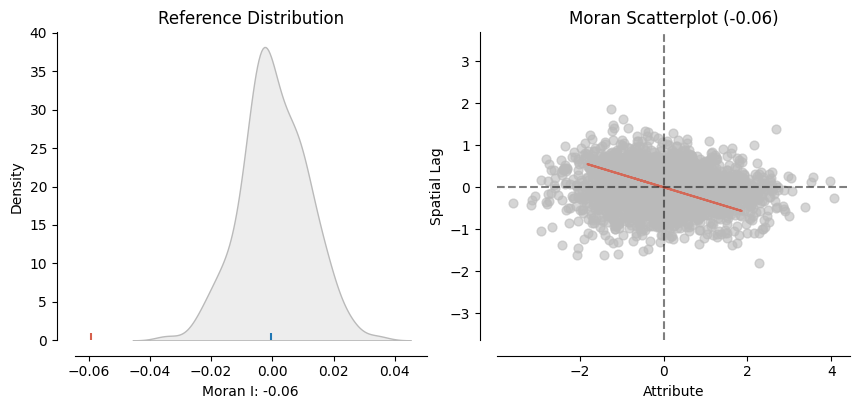

In [48]:
sem_moran = Moran(sem.e_filtered, w, permutations = 199) #199 permutations
plot_moran(sem_moran, zstandard=True, figsize=(10,4))

A Moran's I value of -0.06 suggests a very weak negative spatial autocorrelation. -0.06 is close to 0, generally indicates that the spatial distribution of the variable is close to random.

Text(0.5, 1.0, 'Map of filtered residuals of the SEM model')

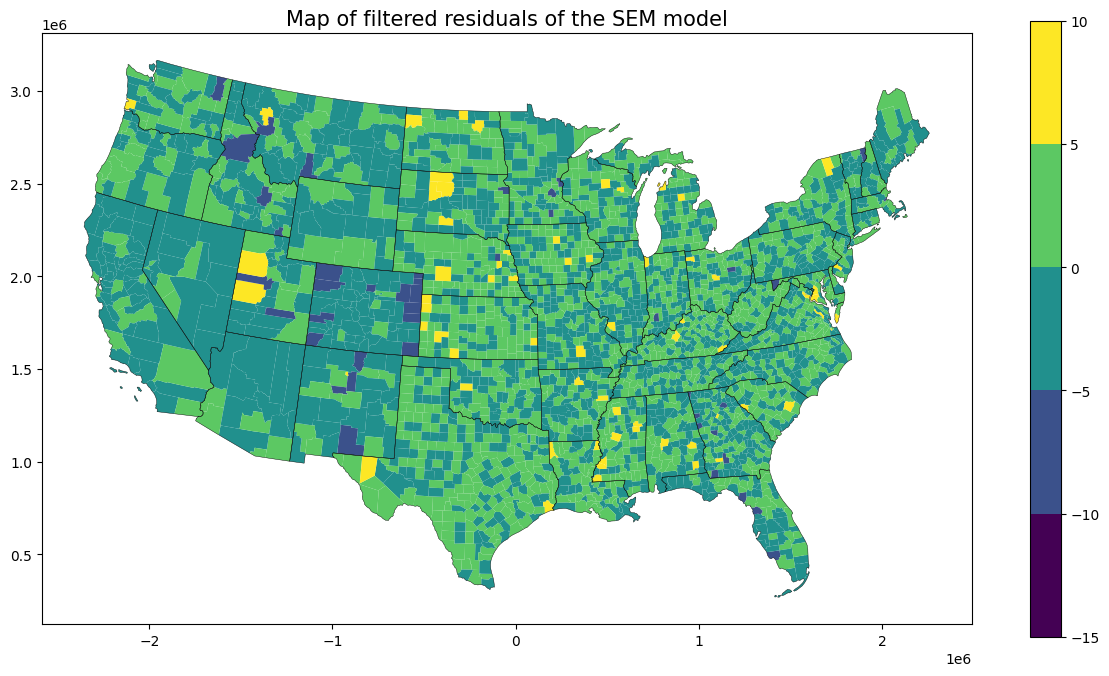

In [49]:
ax = gdf_income_health.plot(column=sem.e_filtered.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)
state.plot(ax=ax,linewidth=0.3,edgecolor="black")
plt.title("Map of filtered residuals of the SEM model",fontsize=15)

### **L-M test**

In [50]:
ols = spreg.OLS(y, X, w=w, spat_diag=True, moran=True,
                name_y='OBESITY', name_x=variable_names)

print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           7
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3096
R-squared           :      0.5392
Adjusted R-squared  :      0.5384
Sum squared residual:     28751.3                F-statistic           :    603.9109
Sigma-square        :       9.287                Prob(F-statistic)     :           0
S.E. of regression  :       3.047                Log likelihood        :   -7857.092
Sigma-square ML     :       9.266                Akaike info criterion :   15728.183
S.E of regression ML:      3.0440                Schwarz criterion     :   15770.464

------------------------------------------------------------

### **Cross-comparison of Lag, Error and OLS models.**

*   The OLS model is not reliable because we know that the assumptions are List item violated.
*   The SEM has the lowest AIC, indicating that it is the preferred model in terms of fitting accuracy to the data.
*   From the L-M Tests, we can expect that the error model is more approproate than the lag model (comparing robust score: 721 vs 44).
*   Additionally, the SEM has a Moran's I value closest to zero, which indicates random residuals.

Based on these criteria, the SEM model would be the preferred model to use for this analysis.

In [51]:
data = {
    'Predictor': ['CONSTANT', 'total_pop', 'sex_ratio', 'median_income', 'gini', 'pct_age_18_29', 'pct_65_over', 'pct_bach', 'lambda', 'AIC', "Moran's I of residuals"],
    'OLS Estimates': [47.50, -0.00, -0.03, -0.00, 8.64, 0.06, -0.19, -0.25, 'NA', 15692.72, 0.48],
    'SLM Estimates': [26.04, -0.00, -0.02, -0.00, 3.87, 0.05, -0.13, -0.18, 0.49, 14689.39, 0.08],
    'SEM Estimates': [47.15, -0.00, -0.00, -0.00, 2.18, 0.01, -0.16, -0.18, 0.71, 14312.46, -0.06]
}

df = pd.DataFrame(data)

df.set_index('Predictor')

df


,Predictor,OLS Estimates,SLM Estimates,SEM Estimates
0,CONSTANT,47.5,26.04,47.15
1,total_pop,-0.0,-0.00,-0.00
2,sex_ratio,-0.03,-0.02,-0.00
3,median_income,-0.0,-0.00,-0.00
4,gini,8.64,3.87,2.18
5,pct_age_18_29,0.06,0.05,0.01
6,pct_65_over,-0.19,-0.13,-0.16
7,pct_bach,-0.25,-0.18,-0.18
8,lambda,NA,0.49,0.71
9,AIC,15692.72,14689.39,14312.46
